# Verifying the Li-Stephens Model inference of the jump rate

This notebook explores a verification of our Li-Stephens Model implementation. Specifically we focus on: (1) estimation of the haplotype copying jump rate when the error rate is given and (2) joint estimation of the jump-rate and the error probability via numerical approximation.

For the joint estimation of the jump-rate and the error probability we are able to obtain the standard errors of each estimate as well by taking the square root of the diagonal of the Hessian matrix. In the case of the marginal jump rate estimation the error probability was fixed at $\epsilon = 10^{-2}$.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import msprime as msp

plt.rcParams['pdf.fonttype'] = 3

import sys
sys.path.append('../../src/')
from plot_utils import *

%matplotlib inline

In [2]:
# Reading in the CSV of results from our various simulations ... 
results_csv = '../../results/ls_verify/ls_simulations_100.csv'
ls_verify_df = pd.read_csv(results_csv)
ls_verify_df.head()

,scales_true,scales_marg_hat,scales_jt_hat,eps_jt_hat,se_scales_jt_hat,se_eps_jt_hat
0,100,102.516313,102.674217,0.019105,24.716874,0.000066
1,200,189.369557,189.650502,0.019182,39.912196,0.000100
2,300,292.669794,293.056054,0.019423,47.277726,0.000085
3,400,417.647663,417.991549,0.019413,40.383416,0.000066
4,500,503.451364,504.012475,0.020576,45.715850,0.000129


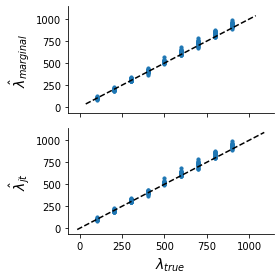

In [3]:
fig, ax = plt.subplots(2,1,figsize=(4,4), sharex=True, sharey=True)
ax[0].scatter(ls_verify_df['scales_true'].values, 
           ls_verify_df['scales_marg_hat'].values, s=10);

ax[1].scatter(ls_verify_df['scales_true'].values, 
           ls_verify_df['scales_jt_hat'].values, s=10);

plot_yx(ax[0], linestyle='--', color='black')
plot_yx(ax[1], linestyle='--', color='black')


ax[1].set_xlabel(r'$\lambda_{true}$', fontsize=14);
ax[1].set_ylabel(r'$\hat{\lambda}_{jt}$', fontsize=14);
ax[0].set_ylabel(r'$\hat{\lambda}_{marginal}$', fontsize=14);

debox(ax[0]); debox(ax[1]);
fig.tight_layout();

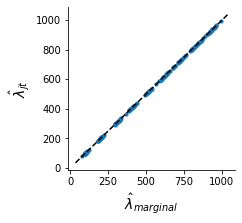

In [4]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(ls_verify_df['scales_marg_hat'], 
           ls_verify_df['scales_jt_hat'], s=10)

debox(ax); 
plot_yx(ax, color='black', linestyle='--');
ax.set_ylabel(r'$\hat{\lambda}_{jt}$', fontsize=14);
ax.set_xlabel(r'$\hat{\lambda}_{marginal}$', fontsize=14);

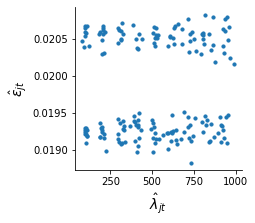

In [5]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(ls_verify_df['scales_jt_hat'], 
           ls_verify_df['eps_jt_hat'], s=10)

debox(ax); 
# plot_yx(ax, color='black', linestyle='--');
ax.set_xlabel(r'$\hat{\lambda}_{jt}$', fontsize=14);
ax.set_ylabel(r'$\hat{\epsilon}_{jt}$', fontsize=14);

# Plotting with thinned SNP data to explore effect of fewer SNPs on estimation

The goal with this data is so that even with subsampling of SNPs that we can be assured that we 
are able to reliably estimate the copying jump-rate. Here we have pushed the extremes from sampling every 5th snp to every 1000th snp. 

The intuition should be that as genetic markers get farther apart, it is increasingly hard to observe short-range haplotype switches (which may lead to a downward bias when the true jump rate is high). 

In [6]:
results_csv2 = '../../results/ls_verify/ls_simulations_49_thinned.csv'
ls_verify2_df = pd.read_csv(results_csv2)
ls_verify2_df.head()

,scales_true,scales_marg_hat,scales_jt_hat,eps_jt_hat,se_scales_jt_hat,se_eps_jt_hat,nsnps,thin,seeds,replicate,min_gen_dist
0,100,116.431791,116.552416,0.018589,17.198715,0.000226,27383,5,1,0,2.575927e-08
1,200,205.179728,205.471844,0.020002,22.616417,0.000234,27383,5,1,0,2.575927e-08
2,300,303.465699,303.562758,0.018040,13.100959,0.000207,27383,5,1,0,2.575927e-08
3,400,401.198880,401.322422,0.018800,12.737886,0.000214,27383,5,1,0,2.575927e-08
4,500,518.136657,518.271315,0.019034,11.716948,0.000215,27383,5,1,0,2.575927e-08


In [7]:
bias_jt = ls_verify2_df.scales_jt_hat - ls_verify2_df.scales_true
bias_marginal = ls_verify2_df.scales_marg_hat - ls_verify2_df.scales_true
ls_verify2_df['bias_jt'] = bias_jt
ls_verify2_df['bias_marginal'] = bias_marginal
ls_verify2_df.groupby(['scales_true','replicate']).agg('mean').head()

,,scales_marg_hat,scales_jt_hat,eps_jt_hat,se_scales_jt_hat,se_eps_jt_hat,nsnps,thin,seeds,min_gen_dist,bias_jt,bias_marginal
scales_true,replicate,,,,,,,,,,,
100,0,106.244979,106.426898,0.020051,13.562857,0.000804,11296.0,41.25,10.0,7.880431e-07,6.426898,6.244979
200,0,211.463481,211.616207,0.020440,10.263735,0.013817,11296.0,41.25,10.0,7.880431e-07,11.616207,11.463481
300,0,320.016267,320.153759,0.021191,8.502748,0.026991,11296.0,41.25,10.0,7.880431e-07,20.153759,20.016267
400,0,435.021825,435.130331,0.021009,6.887649,0.013917,11296.0,41.25,10.0,7.880431e-07,35.130331,35.021825
500,0,557.489560,557.579076,0.020036,5.994418,0.013888,11296.0,41.25,10.0,7.880431e-07,57.579076,57.489560


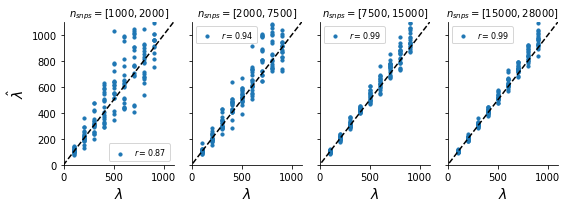

In [8]:
fig, ax = plt.subplots(1,4,figsize=(8,3), sharex=True, sharey=True)
nsnps_unique = np.unique(ls_verify2_df.nsnps)
windows = [1000, 2000, 7500, 15000, 28000]

for i in range(1,len(windows)):
    idx = (ls_verify2_df['nsnps'] < windows[i]) & (ls_verify2_df['nsnps'] > windows[i-1])
    x = ls_verify2_df['scales_true'][idx]
    y = ls_verify2_df['scales_jt_hat'][idx]
    yerr= ls_verify2_df['se_scales_jt_hat'][idx]
    r = np.corrcoef(x,y)[0,1]
    ax[i-1].scatter(x,y, s=10, label=r'$r=%0.2f$' % r)
    plot_yx(ax[i-1], linestyle='--', color='black')
    ax[i-1].set_title(r'$n_{snps}=[%d,%d]$' % (windows[i-1], windows[i]), fontsize=10)
    ax[i-1].set_xlabel(r'$\lambda$', fontsize=14)
    ax[i-1].legend(fontsize=8)

ax[0].set_ylabel(r'$\hat{\lambda}$', fontsize=14)
ax[0].set_ylim(0,1100)
ax[0].set_xlim(0,1100)
debox_all(ax);
plt.tight_layout()

## Plotting the Joint Likelihood Surface

In [91]:
from li_stephens import LiStephensHMM
from tqdm import tqdm

mut_rate = 1e-8
rec_rate = 2e-8
length = 5e6
seed = 42

n = 50
ts = msp.simulate(Ne=1e4, sample_size=n, 
                  mutation_rate=mut_rate, 
                  recombination_rate=rec_rate, length=length, random_seed=seed)
# Generating the haplotype reference panel...
geno = ts.genotype_matrix().T
phys_pos = np.array([v.position for v in ts.variants()])
rec_pos = phys_pos * rec_rate

ac = np.sum(geno, axis=0)
mac = np.minimum(ac, n - ac)
maf = mac / n
idx = np.where(maf > 0.01)[0]

ls_model = LiStephensHMM(haps=geno[:,idx], positions=rec_pos[idx])
test_hap,_ = ls_model._sim_haplotype(scale=1e2, eps=5e-3, seed=42)

x = 20
M = np.zeros(shape=(x,x))

scales=np.linspace(5, 300, x)
eps = np.linspace(5e-3, 5e-2, x)
for i,s in tqdm(enumerate(scales)):
    for j,e in enumerate(eps):
        M[i,j]=ls_model._negative_logll(test_hap, scale=s, eps=e)

20it [01:40,  5.01s/it]


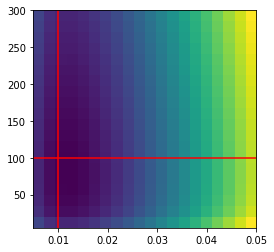

In [94]:

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.imshow(M/M.max(), extent=[5e-3, 5e-2, 5, 300], origin='lower', aspect='auto')
ax.axhline(y=1e2, color='red')
ax.axvline(x=1e-2, color='red')

In [95]:
# ls_model._infer_params(test_hap, x0=[1e2,1e-2], bounds=[(1.,1e4), (1e-4, 0.2)], method='trust-constr', options={'verbose': 1})

In [100]:
from scipy import optimize

test_hap,_ = ls_model._sim_haplotype(scale=5e2, eps=5e-3)

f = lambda x : ls_model._negative_logll(test_hap, scale=x[0], eps=x[1])
bounds = [(1, 1e5), (1e-4, 0.5)]
%time optimize.shgo(f, bounds, n=10, sampling_method='sobol', options={'verbose': 1, 'disp': 1})

Splitting first generation
Generating sampling points
Constructing Gabrial graph and minimizer pool
Triangulation completed, building minimizer pool
Starting minimization at [1.e+00 1.e-04]...
bounds in kwarg:
[[1.0, 100000.0], [0.0001, 0.5]]
lres =      fun: 28518.770356055036
     jac: array([-0.0012207 ,  1.12231445])
 message: 'Optimization terminated successfully'
    nfev: 123
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([5.94559281e+02, 7.08279446e-03])
Successfully completed construction of complex.
CPU times: user 30.4 s, sys: 41 ms, total: 30.4 s
Wall time: 30.4 s


     fun: 28518.770356055036
    funl: array([28518.77035606])
 message: 'Optimization terminated successfully.'
    nfev: 143
     nit: 2
   nlfev: 123
   nlhev: 0
   nljev: 23
 success: True
       x: array([5.94559281e+02, 7.08279446e-03])
      xl: array([[5.94559281e+02, 7.08279446e-03]])